In [17]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

! gpustat

rambo4                         Tue Nov 28 23:49:58 2023  525.125.06
[0] NVIDIA GeForce RTX 2080 Ti | 49°C,   0 % |  7083 / 11264 MB | nadavru(1180M) nadavru(1180M) nadavru(1180M) nadavru(1180M) nadavru(1180M) nadavru(1180M)
[1] NVIDIA GeForce RTX 2080 Ti | 39°C,   0 % |  7851 / 11264 MB | nadavru(1308M) nadavru(1308M) nadavru(1308M) nadavru(1308M) nadavru(1308M) nadavru(1308M)
[2] NVIDIA GeForce RTX 2080 Ti | 47°C,   0 % |  8619 / 11264 MB | nadavru(1436M) nadavru(1436M) nadavru(1436M) nadavru(1436M) nadavru(1436M) nadavru(1436M)
[3] NVIDIA GeForce RTX 2080 Ti | 47°C,   0 % |  7083 / 11264 MB | nadavru(1180M) nadavru(1180M) nadavru(1180M) nadavru(1180M) nadavru(1180M) nadavru(1180M)
[4] NVIDIA GeForce RTX 2080 Ti | 24°C,   0 % |     3 / 11264 MB |
[5] NVIDIA GeForce RTX 2080 Ti | 41°C,   0 % |  7851 / 11264 MB | nadavru(1308M) nadavru(1308M) nadavru(1308M) nadavru(1308M) nadavru(1308M) nadavru(1308M)
[6] NVIDIA GeForce RTX 2080 Ti | 47°C,   0 % |  8619 / 11264 MB | nadavru(1436M) nadav

In [69]:
import pandas as pd
import wfdb
import matplotlib.pyplot as plt

In [19]:
data_path = '/home/liranc6/ecg/ecg_forecasting/data/icentia11k-continuous-ecg'
            #"#/home/liranc6/ecg/state-spaces/data/icentia11k-continuous-ecg"
ProjectPath = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))

To look at patient 9000 and segment 0 the filename would be: p09/09000/p09000_s00 and it can loaded using wfdb as follows:

In [20]:
"""
patient_id=9000
segment_id=0
start=2000
length=1024

filename = f'{data_path}/p0{str(patient_id)[:1]}/p{patient_id:05d}/p{patient_id:05d}_s{segment_id:02d}'

rec = wfdb.rdrecord(filename, sampfrom=start, sampto=start+length)
ann = wfdb.rdann(filename, "atr", sampfrom=start, sampto=start+length, shift_samps=True)
wfdb.plot_wfdb(rec, ann, plot_sym=True, figsize=(15,4));
"""

'\npatient_id=9000\nsegment_id=0\nstart=2000\nlength=1024\n\nfilename = f\'{data_path}/p0{str(patient_id)[:1]}/p{patient_id:05d}/p{patient_id:05d}_s{segment_id:02d}\'\n\nrec = wfdb.rdrecord(filename, sampfrom=start, sampto=start+length)\nann = wfdb.rdann(filename, "atr", sampfrom=start, sampto=start+length, shift_samps=True)\nwfdb.plot_wfdb(rec, ann, plot_sym=True, figsize=(15,4));\n'

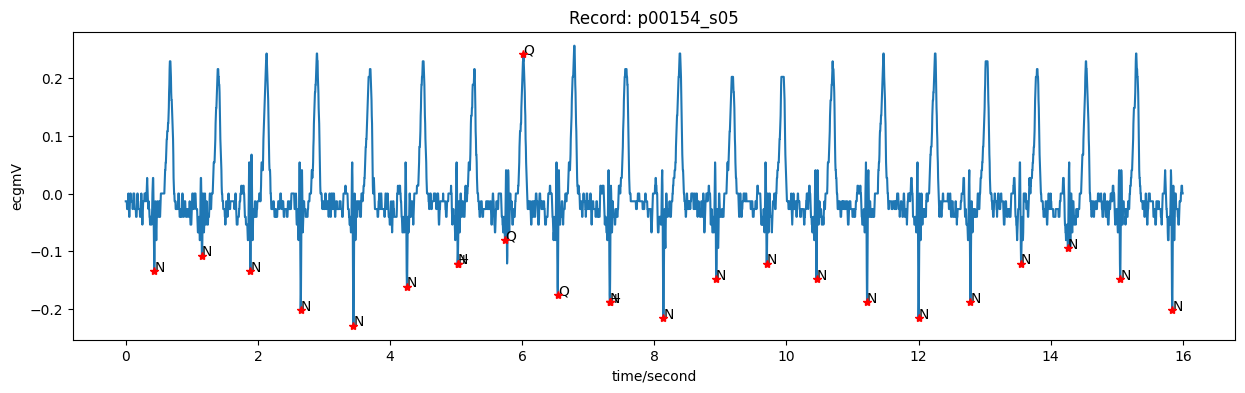

In [21]:
#since I didnt download the whole dataset, I will show on patient 154 and segment 5
patient_id=154
segment_id=5
start=9000*4 + 2000
length=4000

filename = os.path.join(data_path, f'p{patient_id:05d}'[:3],f'p{patient_id:05d}', f'p{patient_id:05d}_s{segment_id:02d}')
rec = wfdb.rdrecord(filename, sampfrom=start, sampto=start+length)
ann = wfdb.rdann(filename, "atr", sampfrom=start, sampto=start+length, shift_samps=True)
wfdb.plot_wfdb(rec, ann, plot_sym=True, figsize=(15,4))

In [22]:
print("Length of the segment: ", len(rec.p_signal))

Length of the segment:  4000


In [23]:
"""
- `N`: Normal beat
- `V`: ESV (PVC): Premature ventricular contraction, premature ventricular contraction - abnormal heartbeat originating in the lower chambers of the heart.
- `Q`: Unclassifiable beat
- `+`: Artifact, which is noise or interference in the ECG signal, not an actual heartbeat.
- `S`: ESSV (PAC): Premature or ectopic supraventricular beat, premature atrial contraction 
"""
# ann.symbol contains the label for each beat. The index in the record is contained in ann.sample
pd.Series(ann.symbol).value_counts()

N    19
Q     3
+     2
Name: count, dtype: int64

In [24]:
# Rhythm is encoded in aux_note. (N starts a normal rhythm and ) ends it.
"""
Rhythms are annotated in ann.aux_note at each timepoint. For example a normal sinusal rhythm will start with a '(N' annotation and then end with a ')' annotation. The entire sequence in between is annotated as a normal sinusal rhythm
"""
pd.Series(ann.aux_note).value_counts()

None    22
)        1
(N       1
Name: count, dtype: int64

In [25]:
# find the time stamp of where '(N' and where ')'
start_index = ann.aux_note.index('(N')
end_index = ann.aux_note.index(')')

start_timestamp = ann.sample[start_index]
end_timestamp = ann.sample[end_index]

print("Start timestamp: ", start_timestamp)
print("End timestamp: ", end_timestamp)

Start timestamp:  1832
End timestamp:  1256


It seems like there might be a misunderstanding. The `index()` function returns the first occurrence of the specified value. In your case, it's returning the first occurrence of '(N' and ')'. However, the end timestamp is smaller than the start timestamp, which is not expected.

If you want to find the start and end timestamps of each '(N' rhythm, you should find the index of the next ')' after each '(N'. Here's how you can modify your code to do this:


In [26]:
# Find the indices of '(N' and the corresponding ')'
start_indices = [i for i, aux_note in enumerate(ann.aux_note) if aux_note == '(N']
end_indices = [i for i, aux_note in enumerate(ann.aux_note) if aux_note == ')' and i > start_indices[-1]]

# Find the timestamps of '(N' and the corresponding ')'
start_timestamps = [ann.sample[i] for i in start_indices]
end_timestamps = [ann.sample[i] for i in end_indices]

print("Start timestamps: ", start_timestamps)
print("End timestamps: ", end_timestamps)

# As we can see, in the given window some rhythm ands and then the Normal sinus starts and its ending is out of the window.

Start timestamps:  [1832]
End timestamps:  []


now to extract all the timestamps of the normal sinus rhythm in the entire segment:

In [27]:
def timestamps_of_normal_rhythms_in_all_segments(filename):
    # Read the annotations
    ann = wfdb.rdann(filename, 'atr')

    # Find the indices of '(N' and the corresponding ')'
    start_indices = [i for i, aux_note in enumerate(ann.aux_note) if aux_note == '(N']
    end_indices = [
        next(i for i, aux_note in enumerate(ann.aux_note[start_index:], start=start_index) if aux_note == ')')
        for start_index in start_indices
    ]

    # Find the timestamps of '(N' and the corresponding ')'
    start_timestamps = [ann.sample[i] for i in start_indices]
    end_timestamps = [ann.sample[i] for i in end_indices]

    # Zip the start and end timestamps together to create tuples
    timestamps = list(zip(start_timestamps, end_timestamps))

    return timestamps

# Example usage
patient_id = 154
segment_id = 5
filename = f"{data_path}/p00/p{patient_id:05d}/p{patient_id:05d}_s{segment_id:02d}"

# Use the function
timestamps = timestamps_of_normal_rhythms_in_all_segments(filename)
print("Timestamps:", timestamps)

Timestamps: [(11551, 13226), (16029, 17875), (22451, 23568), (24154, 39256), (39832, 46831), (53512, 56856), (58142, 61639), (76447, 78010), (78983, 80466), (81499, 82730), (262489, 265223), (397650, 399291), (401255, 402846), (404148, 406902), (602902, 605684), (606952, 609431), (618655, 620189), (621394, 622987), (657684, 661509), (665563, 669069), (734561, 741124), (761163, 766934), (768275, 772549), (775285, 786542), (788411, 819938), (824024, 826535), (836863, 866193), (984307, 997757), (1023717, 1026709), (1035443, 1040526)]



I want to extract the normal sinus rhythms from the entire segment and then to extract the normal sinus rhythms from the entire dataset.

i.e I want to create a subset of the dataset that contains only the normal sinus rhythms.

I created the file data_preparation.py and used the function `extract_sinus_rhythms_to_new_subset()`

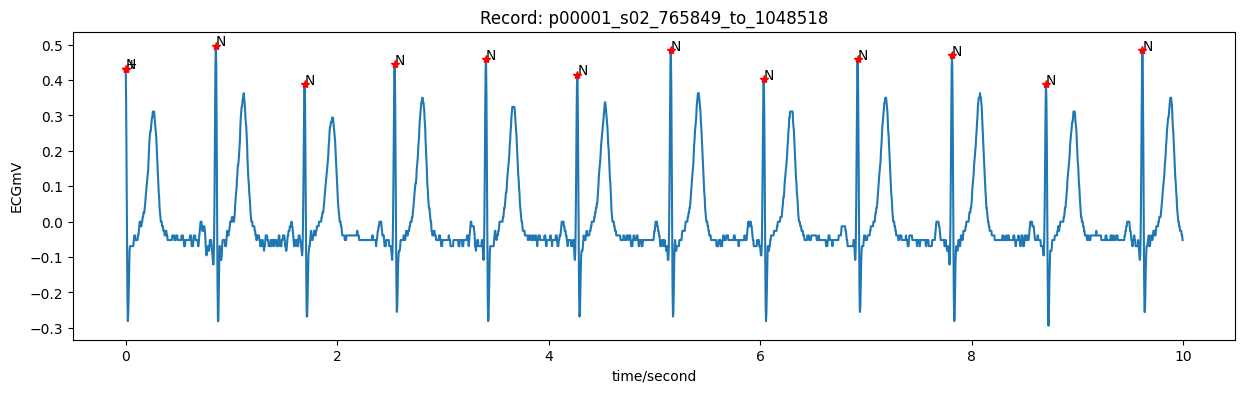

None
N    12
+     1
Name: count, dtype: int64
None    12
(N       1
Name: count, dtype: int64


In [63]:
new_data_path = '/home/liranc6/ecg/ecg_forecasting/data/icentia11k-continuous-ecg_normal_sinus_subset'

#p00001_s02_765849_to_1048518.atr
patient_id=1
segment_id=2
begins_at = 765849
ends_at = 1048518
start=0
length= 10*250 # seconds * samples 

filename = os.path.join(new_data_path, f'p{patient_id:05d}'[:3],f'p{patient_id:05d}',
                        f'p{patient_id:05d}_s{segment_id:02d}_{begins_at}_to_{1048518}')
rec = wfdb.rdrecord(filename, sampfrom=start, sampto=start+length)
ann = wfdb.rdann(filename, "atr", sampfrom=start, sampto=start+length, shift_samps=True)
print(wfdb.plot_wfdb(rec, ann, plot_sym=True, figsize=(15,4)))
print(pd.Series(ann.symbol).value_counts())
print(pd.Series(ann.aux_note).value_counts())

In [66]:
entire_rec = wfdb.rdrecord(filename)
entire_ann = wfdb.rdann(filename, "atr", shift_samps=True)
print(pd.Series(entire_ann.symbol).value_counts())
print(pd.Series(entire_ann.aux_note).value_counts())
print(timestamps_of_normal_rhythms_in_all_segments(filename))

N    1257
+       2
V       2
Name: count, dtype: int64
None    1259
(N         1
)          1
Name: count, dtype: int64
[(0, 282669)]


I need to understand what I want to forecast - its format and structure.

I understood I want to forecast the signal graph, I found it in `rec.p_signal`.
A more advanced thing to do would be to forecast the ann labeling (e.g 'N', 'S', 'a', 'V').
Remembering that the holy grail is to cluster the ['N', 'S', 'a', 'V'] correctly based on the `p_signal`

In [67]:
print(f'{type(rec.p_signal)=}')
print(f'{rec.p_signal.shape=}')
print(f'{rec.sig_len=}')

type(rec.p_signal)=<class 'numpy.ndarray'>
rec.p_signal.shape=(2500, 1)
rec.sig_len=2500


In [74]:
rec.p_signal

array([[ 0.43223201],
       [ 0.32417401],
       [ 0.13399192],
       ...,
       [-0.03890088],
       [-0.03890088],
       [-0.05186784]])

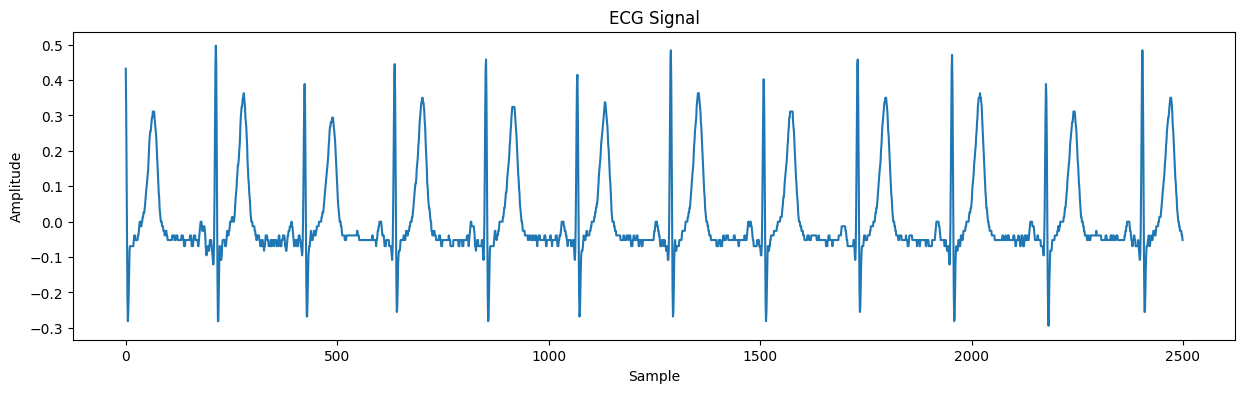

In [70]:
# plot the signal
plt.figure(figsize=(15, 4))
plt.plot(rec.p_signal)
plt.title('ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

TODO next:
I understand the sample/label is the p_signal which its format is np.ndarray.
Hence I can transform the np.ndarray to a tensor and divide it to x and y (9/1 at first)
I need to remember to make the samples in a fixed length, I will split each file into as many examples as possible and ignore the remainder that remains. BUT only in the script, I wont make new files because the length is a parameter I play with.  